In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.datasets import load_files
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, precision_recall_curve, auc, f1_score
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 393 kB/s 


In [ ]:
import keras_tuner as kt

Loading the review-files and their assigned class, 0 for negative and 1 for positive

In [ ]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/mix20_rand700_tokens_0211.tar
!tar xvzf mix20_rand700_tokens_0211.tar

movies = load_files(container_path="tokens") 
x, y = movies.data, movies.target

In [ ]:
# First sample and target
print('Sample: {} \nTarget: {}'.format(x[1], y[1]))   # 1 positive, 0 negative

Sample: b'cast : russell crowe , joaquin phoenix , connie nielsen , oliver reed , derek jacobi , djimon hounsou , richard harris , spencer treat clark written by : david h . franzoni , john logan and william nicholson directed by : ridley scott running time : 157 minutes roman emperor marcus aurelius ( richard harris ) chooses his trusted general maximus ( russell crowe ) as his successor . however the emperor\'s evil son commodus ( joaquin phoenix ) murders his father before the announcement can be made , and maximus ( as well as his family ) is sentenced to be executed . maximus is able to escape his executioners , but is later captured and sold as a slave to proximo ( oliver reed ) . proximo is looking for gladiators to earn himself money ( he being a former gladiator himself ) , and maximus reluctantly uses his skills to prove himself a powerful gladiator . when emperor commodus announces that new games will be held in the colisseum , proximo takes his gladiators there to do battle

Removing unecessary characters from the data

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

docs = []
docs_str=""

for doc in x: 
    
    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))              # \W matches any single letter, number or underscore

    document = re.sub(r'[0-9]',' ', document)

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  # unnecessary
    
    #Remove the bs from the begining.
    document = re.sub(r'^[a-zA-Z]\s+', ' ', document)
    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) # \s+ means a string of whitespace characters

    # Remove all numbers
    #document = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", document)

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    document = document.split()
    
    # Lemmatization
    document = [lemmatizer.lemmatize(word) for word in document]
    
    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(document)

    # Append all documents into a list 'docs'
    docs.append(document)
    docs_str = ''.join(document)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Average document length

In [ ]:
lengths = []
for document in docs:
  lengths.append(len(document))
print(f"The average review length is {int(np.mean(lengths))} characters.")

The average review length is 3560 characters.


Average document length per class

In [ ]:
lengths_negative = []
lengths_positive = []
for i in range(len(docs)):
  if y[i] == 0:
      lengths_negative.append(len(docs[i]))
  else:
      lengths_positive.append(len(docs[i]))
print(f"The average review length for the negative class is {int(np.mean(lengths_negative))} characters.")
print(f"The average review length for the positive class is {int(np.mean(lengths_positive))} characters.")
print(f"The minimum review length for the negative class is {int(min(lengths_negative))} characters.")
print(f"The minimum review length for the positive class is {int(min(lengths_positive))} characters.")
print(f"The max review length for the negative class is {int(max(lengths_negative))} characters.")
print(f"The max review length for the positive class is {int(max(lengths_positive))} characters.")

The average review length for the negative class is 3346 characters.
The average review length for the positive class is 3772 characters.
The minimum review length for the negative class is 380 characters.
The minimum review length for the positive class is 476 characters.
The max review length for the negative class is 10109 characters.
The max review length for the positive class is 9919 characters.


In [ ]:
tokenized_sents = [word_tokenize(i) for i in docs]
tokenized_sents = [item for sublist in tokenized_sents for item in sublist]
print("The vocabulary consists of",str(len(np.unique(tokenized_sents)))+" words.")

The vocabulary consists of 30797 words.


Train test dev split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.2, random_state=13579)

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.25, random_state=13579)

In [ ]:
stop_words = list(set(stopwords.words('english')))

In [ ]:
x_train[0]

'mr nice guy is the latest jackie chan film so you should know what to expect weak plot terrible dialogue very little acting ability but some jaw dropping action sequence that nearly make the rest of it worthwhile however mr nice guy lack the sparkle of jackie best effort and it weakness are more glaring than ever jackie chan play who else jackie this time out he a famous chef who host an australian cooking show not that it ever make difference in the plot there are only two scene of him cooking for the rest of the film somehow he mutates into jackie chan supercop it never doe explain why his character ha such superb martial art skill perhaps he wa in the same cooking class a steven seagal in under siege tv newswoman diana gabrielle fitzpatrick covertly tape drug deal involving kingpin giancarlo richard norton and local gang of tough the demon although she only ha one camcorder somehow the result is full of close ups and multiple angle hmmm shade of broadcast news anyway the goon disco

###TF-IDF implementation
Here, the x_train, x_dev, x_test sets are used as untokenized strings before the removal of stopwords.

In [ ]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000, sublinear_tf = True, stop_words = stopwords.words('english'))

# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)
x_dev_tfidf = vectorizer.transform(x_dev)

print(vectorizer.get_feature_names())

['abandon', 'abandoned', 'ability', 'able', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abyss', 'academy', 'academy award', 'accent', 'accept', 'acceptable', 'accident', 'accidentally', 'acclaimed', 'accomplished', 'according', 'account', 'accurate', 'accused', 'achieve', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'acting ability', 'action', 'action comedy', 'action film', 'action hero', 'action movie', 'action scene', 'action sequence', 'action star', 'action thriller', 'activity', 'actor', 'actress', 'actual', 'actually', 'ad', 'adam', 'adam sandler', 'adaptation', 'adapted', 'add', 'added', 'adding', 'addition', 'address', 'admire', 'admit', 'admittedly', 'adult', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'affair', 'affected', 'affection', 'affleck', 'aforementioned', 'afraid', 'africa', 'african', 'african american', 'afterwards', 'age', 'aged', 'agent', 'aging', 'ago', 'agree', 'agrees', 'ah', 'ahead', 'aid', 'aim', 'aimed', 'air', 'air

In [ ]:
print(f"Shape of the train set before the dimensionality reduction is: {x_train_tfidf.shape}")

Shape of the train set before the dimensionality reduction is: (831, 5000)


We implement SVD to reduce the components to 100 (dimension of each vector).

In [ ]:
# Reduce dimensionality using svd from 5000 to 100
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=1212)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_dev_svd = svd.transform(x_dev_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

In [ ]:
print(f"Shape of the train set after the SVD dimensionality reduction is: {x_train_svd.shape}")

Shape of the train set after the SVD dimensionality reduction is: (831, 100)


We are going to set **two baselines**.<br>For both baselines, **Dummy (majority) Classifier and Logistic Regression**, SVD is implemented on the TF-IDF train, dev and test sets.

In [ ]:
def set_baseline(baseline):
  # Evaluate
  predictions = baseline.predict(x_train_svd)
  score = accuracy_score(y_train, predictions)
  pred_train = baseline.predict_proba(x_train_svd)
  print("Train accuracy: {:.2f}%".format(score*100))

  predictions_dev = baseline.predict(x_dev_svd)
  score = accuracy_score(y_dev, predictions_dev)
  pred_dev = baseline.predict_proba(x_dev_svd)
  print("Dev accuracy: {:.2f}% ".format(score*100))

  predictions_test = baseline.predict(x_test_svd)
  score = accuracy_score(y_test, predictions_test)
  pred_test = baseline.predict_proba(x_test_svd)
  print("Test accuracy: {:.2f}% \n".format(score*100))

  print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
  print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

  #Train Set
  print("\nPrecision, recall, F1 scores for each class(train set)")
  print(classification_report(y_train, predictions,labels=np.array([0,1])))
  print("\nPrecision Recall AUC score for the negative class(train set):")
  precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print("\nPrecision Recall AUC score for the positive class(train set):")
  precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print("\nMacro-averaged Precision Recall AUC score for the train set:")
  print((area_train_1+area_train_2)/2)
  #Dev Set
  print("\nPrecision, recall, F1 scores for each class(dev set)")
  print(classification_report(y_dev, predictions_dev,labels=np.array([0,1])))
  print("\nPrecision Recall AUC score for the negative class(dev set):")
  precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print("\nPrecision Recall AUC score for the positive class(dev set):")
  precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print("\nMacro-averaged Precision Recall AUC score for the dev set:")
  print((area_train_1+area_train_2)/2)
  #Test Set
  print("\nPrecision, recall, F1 scores for each class(test set)")
  print(classification_report(y_test, predictions_test,labels=np.array([0,1])))
  print("\nPrecision Recall AUC score for the negative class (test set):")
  precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print("\nPrecision Recall AUC score for the positive class (test set):")
  precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print("\nMacro-averaged Precision Recall AUC score for the test set:")
  print((area_train_1+area_train_2)/2)


  print("\nConfusion Matrix for test data:")
  plot_confusion_matrix(estimator=baseline, X=x_test_svd, y_true=y_test, values_format = '.0f')

**Baseline 1:** Dummy classifier 

Baseline Dummy (majority) Classifier
Train accuracy: 51.14%
Dev accuracy: 49.46% 
Test accuracy: 46.76% 

#Class 0 in Train dataset: (425,)
#Class 1 in Train dataset: (406,)

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       425
           1       0.00      0.00      0.00       406

    accuracy                           0.51       831
   macro avg       0.26      0.50      0.34       831
weighted avg       0.26      0.51      0.35       831


Precision Recall AUC score for the negative class(train set):
0.7557160048134777

Precision Recall AUC score for the positive class(train set):
0.7442839951865223

Macro-averaged Precision Recall AUC score for the train set:
0.75

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       137
           1       0.00      0.00      0.00      

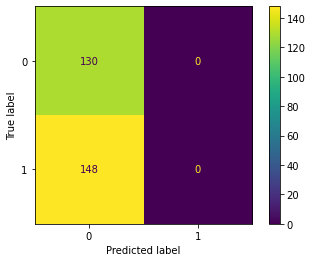

In [ ]:
baseline = DummyClassifier(strategy='most_frequent')

baseline.fit(x_train_svd, y_train)
print("Baseline Dummy (majority) Classifier")
set_baseline(baseline)

**Baseline 2**: Best model from the second assignment, Logistic Regression

Baseline Logistic Regression
Train accuracy: 85.44%
Dev accuracy: 77.98% 
Test accuracy: 78.42% 

#Class 0 in Train dataset: (425,)
#Class 1 in Train dataset: (406,)

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       425
           1       0.86      0.84      0.85       406

    accuracy                           0.85       831
   macro avg       0.85      0.85      0.85       831
weighted avg       0.85      0.85      0.85       831


Precision Recall AUC score for the negative class(train set):
0.9323941651005087

Precision Recall AUC score for the positive class(train set):
0.9335693519530497

Macro-averaged Precision Recall AUC score for the train set:
0.9329817585267792

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       137
           1       0.80      0.75      0.77

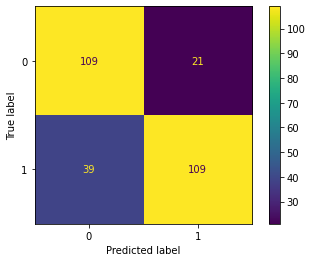

In [ ]:
# Solver -- Algorithm to use in the optimization problem.
clf = LogisticRegression(solver="liblinear", C=1, max_iter=100, tol=0.0001)
clf.fit(x_train_svd, y_train)
print("Baseline Logistic Regression")
set_baseline(clf)

Hyper-parameter tuning with Keras-tuner to define the the architecture of our MLP model.

In [ ]:
my_dir = os.getcwd()+'/drive/MyDrive/text_analytics_3'

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
        EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, restore_best_weights=True)]
                                                                          # If False, the model weights obtained at the last step of training are used.
                                                                          # else, restores weights from the best epoch in that set.

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [256,512]),
      hp.Choice('activation', ['relu'])))                                                    # activation can also be hypertuned with hp.Choice
                                                                                             # ALL paramaters could potentially be hypertuned (batch_size, min_delta, patience,...)
  if hp.Boolean("dropout"+"_1st"):
    model.add(keras.layers.Dropout(hp.Choice('rate'+"_1st", [0.2, 0.35]))) 
  for i in range(hp.Int('layers', 1, 2)):                                                    # from 1-2 Dense layers
    model.add(keras.layers.Dense(hp.Choice('units' + str(i), [256,512]),
                                    activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
    if hp.Boolean("dropout"+str(i)):
        model.add(keras.layers.Dropout(hp.Choice('rate'+str(i), [0.5])))

  model.add(keras.layers.Dense(1, hp.Choice('activation', ['sigmoid'])))
  model.compile(loss='binary_crossentropy', metrics = "accuracy")                            # optimizer and other parameters (e.g. patience) can also be hypertuned
  return model                                                                               # but because of time complexity, only some specific parameters
                                                                                             # were hypertuned indicatively

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss', seed = 11, overwrite = True, directory = my_dir, max_trials = 600)

In [ ]:
tuner.search(x_train_svd, y_train, epochs=40, callbacks=callbacks, validation_data=(x_dev_svd, y_dev))

Trial 506 Complete [00h 00m 03s]
val_loss: 0.5432108044624329

Best val_loss So Far: 0.470020055770874
Total elapsed time: 00h 37m 19s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in /content/drive/MyDrive/text_analytics_3/untitled_project
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 512
activation: relu
dropout_1st: False
layers: 1
units0: 512
act_0: relu
dropout0: False
rate_1st: 0.2
rate0: 0.5
units1: 256
act_1: sigmoid
dropout1: True
rate1: 0.5
Score: 0.470020055770874


In [ ]:
best_model = tuner.get_best_models()[0]       # we do not use it, since we build the MLP's architecture from scratch

Below as comments, the results of the MLP as product of the keras-tuner are presented. These results were not included in the report, but are left here for further discussion/investigation.

In [ ]:
# history1 = best_model.fit(x_train_svd, y_train, epochs=40, callbacks=callbacks, validation_data=(x_dev_svd, y_dev)) #, batch_size=32, shuffle=True)

Epoch 1/40
26/26 [==============================] - 3s 36ms/step - loss: 0.3003 - accuracy: 0.9061 - val_loss: 0.6048 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 2/40
26/26 [==============================] - 0s 17ms/step - loss: 0.2921 - accuracy: 0.8965 - val_loss: 0.5678 - val_accuracy: 0.8014 - lr: 0.0010
Epoch 3/40
26/26 [==============================] - 1s 21ms/step - loss: 0.2134 - accuracy: 0.9254 - val_loss: 0.5465 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 4/40
26/26 [==============================] - 1s 23ms/step - loss: 0.1887 - accuracy: 0.9507 - val_loss: 0.6284 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 5/40
26/26 [==============================] - 1s 23ms/step - loss: 0.1230 - accuracy: 0.9747 - val_loss: 1.2765 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 6/40
26/26 [==============================] - 1s 23ms/step - loss: 0.1014 - accuracy: 0.9783 - val_loss: 1.7669 - val_accuracy: 0.6931 - lr: 0.0010


In [ ]:
# best_model.evaluate(x_train_svd, y_train)

26/26 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9723


[0.14579704403877258, 0.9723225235939026]

In [ ]:
# best_model.evaluate(x_dev_svd, y_dev)

9/9 [==============================] - 0s 5ms/step - loss: 0.5465 - accuracy: 0.7942


[0.5464707612991333, 0.7942238450050354]

In [ ]:
# best_model.evaluate(x_test_svd, y_test)

9/9 [==============================] - 0s 9ms/step - loss: 0.7209 - accuracy: 0.7770


[0.720866322517395, 0.7769784331321716]

In [ ]:
# best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 314,881
Trainable params: 314,881
Non-trainable params: 0
_________________________________________________________________


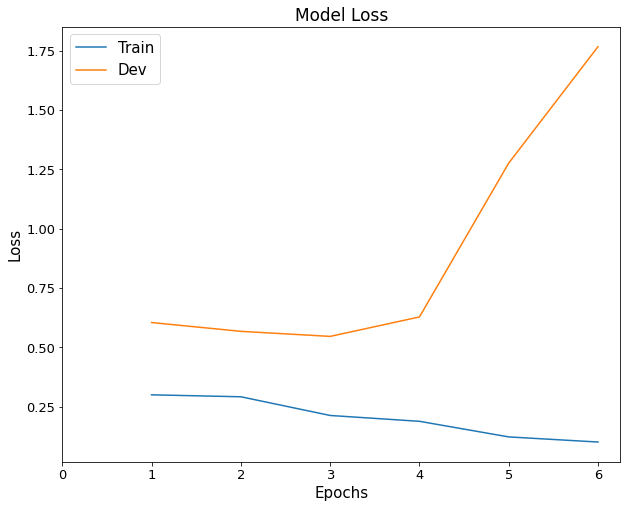

In [ ]:
# # Learning Curves Loss-Epochs
# plt.figure(figsize=(10,8))
# plt.plot(history1.history['loss'])
# plt.plot(history1.history['val_loss'])
# plt.title('Model Loss', fontsize=17)
# plt.ylabel('Loss', fontsize=15)
# plt.xlabel('Epochs', fontsize=15)
# plt.legend(['Train', 'Dev'], loc='upper left', fontsize = 15)
# plt.xticks(range(-1,6), range(7), fontsize=13)
# plt.yticks(fontsize=13)
# # plt.grid()
# plt.show()

Choice of approach: Architecture of the MLP from **scratch** based on the best parameter values provided by the Keras-tuner results.

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=x_train_svd.shape[1], activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(
      loss='binary_crossentropy', # Cross-entropy is the default loss function to use for binary classification problems!!!!!!!!!
      metrics=["accuracy"]
      )

history2 = model.fit(x_train_svd, y_train, epochs=40, callbacks=callbacks, validation_data=(x_dev_svd, y_dev)) # early_stopping_monitor.stopped_epoch
# max(history.history['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               51712     
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 314,881
Trainable params: 314,881
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
26/26 [==============================] - 1s 23ms/step - loss: 0.6271 - accuracy: 0.6631 - val_loss: 0.5819 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 2/40
26/26 [==============================] - 0s 11ms/step - loss: 0.4256 - accuracy: 0.8171 - val_loss: 0.4835 - val_accuracy: 0.7870 - lr: 0.0010

In [ ]:
model.evaluate(x_train_svd, y_train)

26/26 [==============================] - 0s 4ms/step - loss: 0.1955 - accuracy: 0.9266


[0.19550767540931702, 0.9265944361686707]

In [ ]:
model.evaluate(x_dev_svd, y_dev)

9/9 [==============================] - 0s 4ms/step - loss: 0.4448 - accuracy: 0.7906


[0.4447816014289856, 0.7906137108802795]

In [ ]:
model.evaluate(x_test_svd, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 0.4292 - accuracy: 0.8129


[0.4291715621948242, 0.8129496574401855]

Learning Curves of the train and dev sets indicating the loss of the MLP as a function of epochs.

In [ ]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

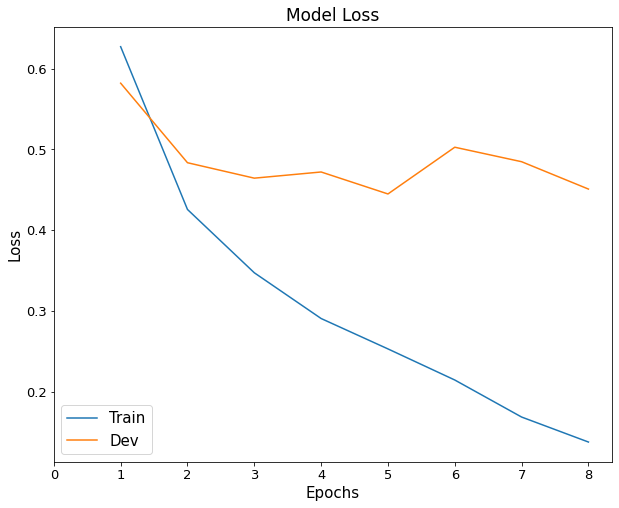

In [ ]:
# Learning Curves Loss-Epochs
plt.figure(figsize=(10,8))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train', 'Dev'], loc='lower left', fontsize = 15)
plt.xticks(range(-1,8), range(9), fontsize=13)
plt.yticks(fontsize=13)
# plt.grid()
plt.show()

Experimental characteristics-results of the MLP

In [ ]:
def report(x, y, set_type):
  probs_belong_to_class_1 = model.predict(x)
  probs_belong_to_class_0 = 1-probs_belong_to_class_1
  predict_proba_preds = np.concatenate((probs_belong_to_class_0, probs_belong_to_class_1), axis = 1)

  print(f"\nPrecision, recall, F1 scores for each class({set_type} set)")
  print(classification_report(y, np.round(model.predict(x)).astype("int32"), labels=np.array([0,1])))
                                    # (model.predict(x_train_svd) >= 0.5).astype("int32")

  print(f"\nPrecision Recall AUC score for the negative class({set_type} set):")
  precision, recall, thresholds = precision_recall_curve(y, predict_proba_preds[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print(f"\nPrecision Recall AUC score for the positive class({set_type} set):")
  precision, recall, thresholds = precision_recall_curve(y, predict_proba_preds[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print(f"\nMacro-averaged Precision Recall AUC score for the {set_type} set:")
  print((area_train_1+area_train_2)/2)

Results of the train set:

In [ ]:
# Train set
report(x_train_svd, y_train, "train")


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       425
           1       0.95      0.89      0.92       406

    accuracy                           0.93       831
   macro avg       0.93      0.93      0.93       831
weighted avg       0.93      0.93      0.93       831


Precision Recall AUC score for the negative class(train set):
0.9831038371925986

Precision Recall AUC score for the positive class(train set):
0.9831022409623265

Macro-averaged Precision Recall AUC score for the train set:
0.9831030390774625


Results of the dev set:

In [ ]:
# Dev set
report(x_dev_svd, y_dev, "dev")


Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       137
           1       0.80      0.78      0.79       140

    accuracy                           0.79       277
   macro avg       0.79      0.79      0.79       277
weighted avg       0.79      0.79      0.79       277


Precision Recall AUC score for the negative class(dev set):
0.8817744263240535

Precision Recall AUC score for the positive class(dev set):
0.8605324574738351

Macro-averaged Precision Recall AUC score for the dev set:
0.8711534418989443


Results of the test set:

In [ ]:
# Test set
report(x_test_svd, y_test, "test")


Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       130
           1       0.85      0.78      0.82       148

    accuracy                           0.81       278
   macro avg       0.81      0.81      0.81       278
weighted avg       0.82      0.81      0.81       278


Precision Recall AUC score for the negative class(test set):
0.8558188004118252

Precision Recall AUC score for the positive class(test set):
0.9040022024642915

Macro-averaged Precision Recall AUC score for the test set:
0.8799105014380584
